In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
data_dir = 'cell_images' 

train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),      
    transforms.RandomHorizontalFlip(),    
    transforms.RandomRotation(10),        
    transforms.ToTensor(),                 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

val_test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms) 
print(f"Found {len(full_dataset)} images in {len(full_dataset.classes)} classes.")
print(f"Classes: {full_dataset.classes}")

Found 27558 images in 2 classes.
Classes: ['Parasitized', 'Uninfected']


In [ ]:
train_size = int(0.7 * len(full_dataset)) 
val_size = int(0.15 * len(full_dataset))  
test_size = len(full_dataset) - train_size - val_size 

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms


print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training set size: 19290
Validation set size: 4133
Test set size: 4135


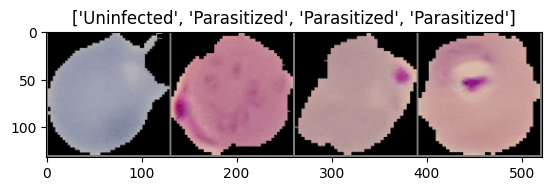

In [5]:
import torchvision


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean 
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

images, classes = next(iter(train_loader))
sample_images = images[:4] 
sample_classes = classes[:4]

out = torchvision.utils.make_grid(sample_images)
class_names = full_dataset.classes
imshow(out, title=[class_names[x] for x in sample_classes])

In [29]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(ImprovedCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) 
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.dropout1 = nn.Dropout(0.25) 

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.dropout2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.dropout3 = nn.Dropout(0.25)
        self.pool4 = nn.AvgPool2d(kernel_size=2, stride=1)
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(128 * 15 * 15, 512) 
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.3) 
        
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        # x = self.dropout1(x)
        
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        # x = self.dropout2(x)
        
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        # x = self.dropout3(x)
        
        x = self.pool4(x)
        x = self.flatten(x) 
        
        x = self.relu4(self.fc1(x))
        x = self.dropout4(x)
        
        x = self.fc2(x)
        return x
model = ImprovedCNN(num_classes=2).to(device)
print(model)

ImprovedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): AvgPool2d(kernel_size=2, stride=1, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28800, out_features=512, bias=True)
  (relu4)

In [30]:
# # Transfer Learning uchun misol (agar SimpleCNN etarli bo'lmasa)
# model_ft = models.resnet18(pretrained=True) # Oldindan o'rgatilgan ResNet18
# num_ftrs = model_ft.fc.in_features # Oxirgi qatlamdagi kirishlar soni

# # ResNet ning oxirgi qatlamini bizning vazifamizga moslashtirish
# model_ft.fc = nn.Linear(num_ftrs, len(full_dataset.classes))
# model_ft = model_ft.to(device)

# # Agar faqat oxirgi qatlamni o'rgatmoqchi bo'lsangiz:
# # for param in model_ft.parameters():
# #     param.requires_grad = False
# # model_ft.fc.requires_grad = True

# # model = model_ft # Agar transfer learning modelini ishlatsangiz
# # print(model)

In [31]:
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-5) 
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_accuracy = 0.0
    best_model_path = "best_malaria_cnn_model.pth"

    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval() 
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad(): 
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} => "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        if epoch_val_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved to {best_model_path} with validation accuracy: {best_val_accuracy:.4f}")
            
    print('Finished Training')
    return train_losses, val_losses, train_accuracies, val_accuracies, best_model_path

num_epochs = 30
train_losses, val_losses, train_accuracies, val_accuracies, best_model_path = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs
)

Epoch 1/30 => Train Loss: 0.3792, Train Acc: 0.8315 | Val Loss: 0.2355, Val Acc: 0.9202
Best model saved to best_malaria_cnn_model.pth with validation accuracy: 0.9202
Epoch 2/30 => Train Loss: 0.1855, Train Acc: 0.9340 | Val Loss: 0.1565, Val Acc: 0.9436
Best model saved to best_malaria_cnn_model.pth with validation accuracy: 0.9436
Epoch 3/30 => Train Loss: 0.1604, Train Acc: 0.9442 | Val Loss: 0.1549, Val Acc: 0.9504
Best model saved to best_malaria_cnn_model.pth with validation accuracy: 0.9504
Epoch 4/30 => Train Loss: 0.1466, Train Acc: 0.9494 | Val Loss: 0.1546, Val Acc: 0.9482
Epoch 5/30 => Train Loss: 0.1398, Train Acc: 0.9528 | Val Loss: 0.1416, Val Acc: 0.9533
Best model saved to best_malaria_cnn_model.pth with validation accuracy: 0.9533
Epoch 6/30 => Train Loss: 0.1340, Train Acc: 0.9538 | Val Loss: 0.1281, Val Acc: 0.9560
Best model saved to best_malaria_cnn_model.pth with validation accuracy: 0.9560
Epoch 7/30 => Train Loss: 0.1286, Train Acc: 0.9549 | Val Loss: 0.1307, 

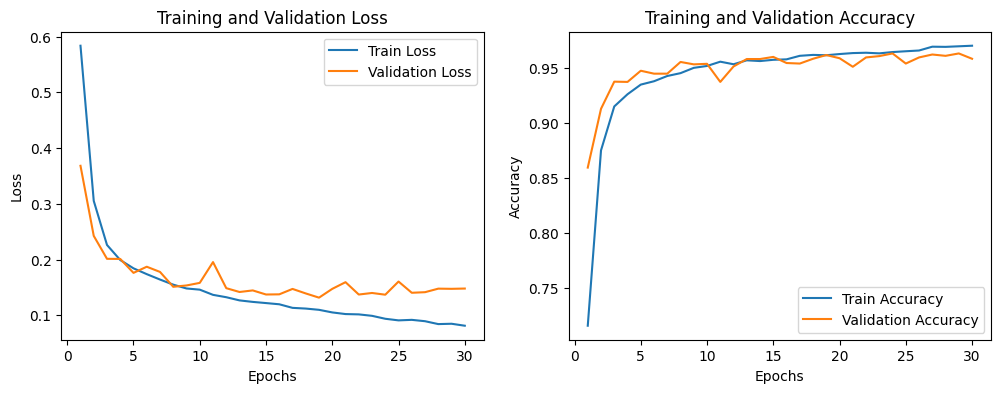

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

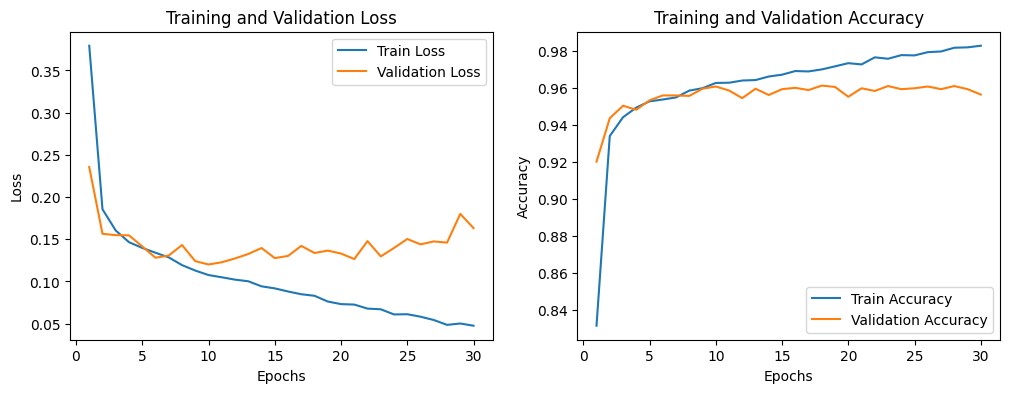

In [32]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()